### Converting Point of View for Virtual Assistants using Huggingface transformers

In [ ]:
## Imports
!pip install transformers[torch] datasets sacrebleu evaluate accelerate --quiet
from huggingface_hub import notebook_login
import random
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly
import seaborn as sns
import spacy
import accelerate
import evaluate
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, pipeline, Seq2SeqTrainer


# set options
pd.set_option('max_colwidth', None) # show full text
random.seed(42)
metric = evaluate.load("sacrebleu") #https://www.youtube.com/watch?v=M05L1DhFqcw

In [ ]:
## Login into Huggingface
notebook_login()

In [ ]:
## Download data
!wget -P /content/data https://raw.githubusercontent.com/alexa/alexa-point-of-view-dataset/main/data/train.tsv
!wget -P /content/data https://raw.githubusercontent.com/alexa/alexa-point-of-view-dataset/main/data/test.tsv
!wget -P /content/data https://raw.githubusercontent.com/alexa/alexa-point-of-view-dataset/main/data/dev.tsv
!wget -P /content/data https://raw.githubusercontent.com/alexa/alexa-point-of-view-dataset/main/data/total.tsv

In [ ]:
## Read Data

train_df = pd.read_csv(f"/content/data/train.tsv", sep="\t", dtype={"input": str, "output": str})
test_df = pd.read_csv(f"/content/data/test.tsv", sep="\t", dtype={"input": str, "output": str})
dev_df = pd.read_csv(f"/content/data/dev.tsv", sep="\t", dtype={"input": str, "output": str})
total_df = pd.read_csv(f"/content/data/total.tsv", sep="\t", dtype={"input": str, "output": str})
print("Train", train_df.shape)
print("Test", test_df.shape)
print("Dev", dev_df.shape)
print("Total", total_df.shape)
train_df.head()

Train (32593, 2)
Test (6985, 2)
Dev (6984, 2)
Total (46562, 2)


,input,output
0,can you remind @CN@ to meet the beautician,"hi @CN@, @SCN@ reminds you to meet the beautician"
1,tell @CN@ to select a spot for the picinc,"hi @CN@ , @SCN@ asks you to select a spot for the picinc"
2,ask @CN@ to answer the call,"hi @CN@ , @SCN@ requested you to answer the call."
3,can you tell @CN@ that the scores are tie,"hey @CN@ , @SCN@ would like you to know that the scores are tie"
4,"could you please ask @CN@ , does julie drink tea?","hi @CN@ , @SCN@ would like to know, if julie drink tea?"


In [ ]:
## Configs
MAX_LEN = 128

In [ ]:
## Utility functions
def compute_metrics(eval_preds):
    preds, labels = eval_preds
    # In case the model returns more than the prediction logits
    if isinstance(preds, tuple):
        preds = preds[0]

    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    # Replace -100s in the labels as we can't decode them
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Some simple post-processing
    decoded_preds = [pred.strip() for pred in decoded_preds]
    decoded_labels = [[label.strip()] for label in decoded_labels]

    result = metric.compute(predictions=decoded_preds, references=decoded_labels)
    return {"bleu": result["score"]}

def get_response(input_text,num_return_sequences=1,num_beams=1):
  batch = tokenizer([input_text],truncation=True,padding='longest',max_length=MAX_LEN, return_tensors="pt")
  model.to("cpu")
  translated = model.generate(**batch,max_length=MAX_LEN,num_beams=num_beams, num_return_sequences=num_return_sequences, temperature=1.5)
  tgt_text = tokenizer.batch_decode(translated, skip_special_tokens=True)
  return tgt_text

In [ ]:
## Create dataset
from datasets import load_dataset

raw_datasets = load_dataset("/content/data/")
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['input', 'output'],
        num_rows: 32593
    })
    validation: Dataset({
        features: ['input', 'output'],
        num_rows: 6984
    })
    test: Dataset({
        features: ['input', 'output'],
        num_rows: 6985
    })
})

In [ ]:
## Tokenizer
model_checkpoint = "t5-base"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, return_tensors="pt", model_max_length=MAX_LEN)

In [ ]:
## Tokenize the dataset

def tokenize_function(example):
  return tokenizer(example["input"], truncation=True, text_target=example["output"], max_length=MAX_LEN)

tokenized_datasets = raw_datasets.map(tokenize_function, batched=True, remove_columns=["input", "output"])
tokenized_datasets

Map:   0%|          | 0/32593 [00:00<?, ? examples/s]

Map:   0%|          | 0/6984 [00:00<?, ? examples/s]

Map:   0%|          | 0/6985 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 32593
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 6984
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 6985
    })
})

In [ ]:
## Model
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [ ]:
## Training

args = Seq2SeqTrainingArguments(
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=3,
    predict_with_generate=True,
    fp16=True,
    push_to_hub=True,
    output_dir="/output/"
)

trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()

You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Bleu
1,0.379100,0.316830,65.398939
2,0.338200,0.294510,66.231729
3,0.325100,0.289021,66.316524


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


TrainOutput(global_step=3057, training_loss=0.3833782157361371, metrics={'train_runtime': 1036.3465, 'train_samples_per_second': 94.35, 'train_steps_per_second': 2.95, 'total_flos': 2557564861178880.0, 'train_loss': 0.3833782157361371, 'epoch': 3.0})

In [ ]:
## Check BLEU score on test
trainer.evaluate(eval_dataset=tokenized_datasets["test"])

{'eval_loss': 0.2910928726196289,
 'eval_bleu': 65.89743841492657,
 'eval_runtime': 71.5301,
 'eval_samples_per_second': 97.651,
 'eval_steps_per_second': 1.538,
 'epoch': 3.0}

In [ ]:
translated = trainer.predict(tokenized_datasets["test"], max_length=20)

In [ ]:
test_df["predicted"] = tokenizer.batch_decode(translated[0], skip_special_tokens=True)

In [ ]:
test_df

,input,output,predicted
0,"ask @CN@ ,how come i can't see her?","hi @CN@ , @SCN@ requests to know why she couldn’t see her","hi @CN@, @SCN@ is asking how come he can't"
1,can you ask @CN@ to setup a auto payment,"hey @CN@ , @SCN@ would like you to setup a auto payment","hi @CN@, @SCN@ asked you to setup a auto payment."
2,can you ask @CN@ the address he wants to meet at?,"@CN@, @SCN@ would like to know the address to where to meet them at.","hi @CN@, @SCN@ wants to know the address you want to meet at"
3,"ask @CN@ , what book did you buy?","hey @CN@ , @SCN@ needs to know what book did you buy?","hey @CN@, @SCN@ is asking what book did you buy?"
4,ask @CN@ about her interest in hosting a show,"hey @CN@ , @SCN@ is asking about your interest in hosting a show","hi @CN@, @SCN@ would like to know about your interest in hosting"
...,...,...,...
6980,please tell @CN@ not to roam outside,"hi @CN@ , @SCN@ told you to roam outside.","hi @CN@, @SCN@ told you not to roam outside."
6981,ask @CN@ for the tution fees,"hi @CN@ , @SCN@ would like to have the tution fees","hi @CN@, @SCN@ would like to know for the tution"
6982,please ask @CN@ if they carry soap & glory products,"hi @CN@, @SCN@ wants to know if you carry soap & glory products?","hi @CN@, @SCN@ is asking if they carry soap &"
6983,"ask @CN@ , can you bring the vegetables upstairs","hey @CN@ , @SCN@ wants to know if you can bring the vegetables upstairs","hey @CN@, @SCN@ is wondering if you can bring the"


In [ ]:
test_df.input.apply(len).min(), test_df.input.apply(len).mean(), test_df.input.apply(len).max()

(14, 41.728131710808874, 188)

In [ ]:
test_df.predicted.apply(len).min(), test_df.predicted.apply(len).mean(), test_df.predicted.apply(len).max()

(19, 51.64166070150322, 80)

In [ ]:
test_df["bleu_score"] = test_df.apply(lambda row: metric.compute(predictions=[row["predicted"]], references=[[row["output"]]])["score"], axis=1)

In [ ]:
test_df.head()

,input,output,predicted,bleu_score
0,"ask @CN@ ,how come i can't see her?","hi @CN@ , @SCN@ requests to know why she couldn’t see her","hi @CN@, @SCN@ is asking how come he can't",44.578343
1,can you ask @CN@ to setup a auto payment,"hey @CN@ , @SCN@ would like you to setup a auto payment","hi @CN@, @SCN@ asked you to setup a auto payment.",67.390471
2,can you ask @CN@ the address he wants to meet at?,"@CN@, @SCN@ would like to know the address to where to meet them at.","hi @CN@, @SCN@ wants to know the address you want to meet at",45.479000
3,"ask @CN@ , what book did you buy?","hey @CN@ , @SCN@ needs to know what book did you buy?","hey @CN@, @SCN@ is asking what book did you buy?",69.965792
4,ask @CN@ about her interest in hosting a show,"hey @CN@ , @SCN@ is asking about your interest in hosting a show","hi @CN@, @SCN@ would like to know about your interest in hosting",56.351901


In [ ]:
test_df.to_csv("test_converted_t5_HF.csv", index=False)

<ipython-input-40-ec5be52f3734>:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


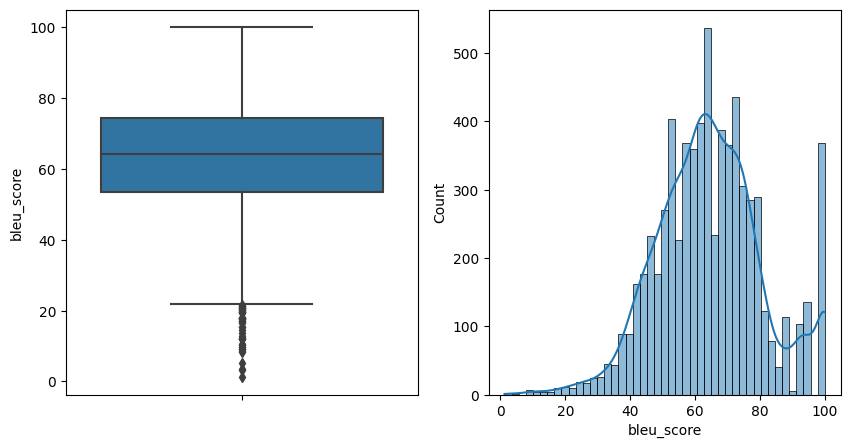

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Boxplot of distribution of BLEU scores for predicted message")
plt.subplot(1,2,1)
sns.boxplot(test_df, y="bleu_score")
plt.subplot(1,2,2)
sns.histplot(test_df, x="bleu_score", kde=True);

### Examples that went wrong

In [ ]:
train_processed = test_df.copy()
train_processed_sorted = train_processed.sort_values("bleu_score", ascending=False)

In [ ]:
train_processed_sorted.tail(20)

,input,output,predicted,bleu_score
2203,ask leanord to pick me up after work,"hi @CN@, they want you to pick them up","hey leanord, leanord is asking you to pick me up",14.473711
2671,please tell @CN@ that tommorow's dinner is cancel,texting @CN@ that dinner is cancel tomorrow,"hi @CN@, @SCN@ informs you that tommorow'",13.545994
4941,tell him to go hospital,"hey @CN@ , @SCN@ is asking to go hospital","hey, i told you to go hospital.",12.929368
3765,can you pick jonah up from school?,@CN@ would like you to pick jonah up from school,"hi, jonah, i am wondering if you can pick jonah up",12.356221
3981,can you tell @CN@ michael has a house across the georges river.,@SCN@ says michael has a house across the georges river.,"hi @CN@, @SCN@ wants you to know that michael has",12.300686
723,can you ask @CN@ where the documents are regarding the sweet gwen case?,"hey, @CN@ where are those documents on the s. gwen case?","hi @CN@, @SCN@ is asking where the documents are regarding the sweet",12.039218
2175,i am the boss.,@SCN@ wants you to know they are the boss.,"hey, i am the boss.",11.967409
163,please ask @CN@ spitting on their last holiday,@SCN@ wants to know about your last holiday,"hi @CN@, @SCN@ is asking if you are spitting",10.571071
4306,ask @CN@ to come to my friend's birthday party,@SCN@ invite's you for their friend's birthday party,"hi @CN@, @SCN@ is asking you to come to their friend'",10.343603
4188,please let me know if dr james wants me to come tomorrow.,"good day dr james, @CN@ is wondering if they should come tomorrow.","hi, dr james, i want to know if you want me",9.809884
